In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from scipy.integrate import solve_ivp, quad
from scipy.optimize import fsolve
cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

$$ V(x) = \frac{1}{2}kx^2 $$
$$ P(x) = \sqrt{\frac{k}{2\pi k_BT}} \,\exp\left(-\frac{\frac{1}{2}kx^2}{k_BT}\right) $$

In [2]:
# Starting over ...
class Oscillator:
    def __init__(self, k=1, x0=0, kT=0.15, xmin=-2, xmax=2):
        self.k = k
        self.x0 = x0
        self._kT = kT
        self.xmin = xmin
        self.xmax = xmax
        self.potential = lambda x: 0.5*k*(x-x0)**2
        self.probability = lambda x: (k/(2*np.pi*kT))**0.5 * np.exp(-self.potential(x)/kT)
        self.sample = None
        self.direct_sample = None
    
    @property
    def kT(self):
        return self._kT
    @kT.setter
    def kT(self, new_kT):
        if self._kT != new_kT:
            self._kT = new_kT
            self.sample = None
    
    def direct_integration(self, function=None):
        if function is none:
            function = self.potential
        # I define the integrands, integrate them, and return the result
        numerator_inner = lambda x: function(x)*np.exp(-self.potential(x)/self._kT)
        numerator = quad(numerator_inner, -np.inf, np.inf)[0]
        denominator_inner = lambda x: np.exp(-self.potential(x)/self._kT)
        denominator = quad(denominator_inner, -np.inf, np.inf)[0]
        return numerator / denominator

    def setup_sample(self, N=100000):
        # Keep only the values for which a random number is below the probability distribution
        xs = np.linspace(self.xmin, self.xmax, N)
        self.sample = [x for x in xs if np.random.rand() < self.probability(x)]
    
    def setup_direct_sample(self, N=100000):
        # First, I define the y-range of the probability distribution
        xs = np.linspace(self.xmin, self.xmax, N)
        probabilities = self.probability(xs)
        ymin = 0
        ymax = 2*np.max(probabilities)

        # Then keep only the values that are below the probability distribution
        xs = np.random.uniform(self.xmin, self.xmax, N)
        self.direct_samples = [
        x for x in xs
        if np.random.uniform(ymin, ymax) < self.probability(x)
        ]
    
    def plot(self, ax, xwidth=0.1, show_V_avg=True, show_V_avg_direct=True):
        # Plot the potential and probability distribution
        xs = np.linspace(self.xmin, self.xmax, 100)
        ax.plot(xs, self.potential(xs), label='Potential')
        ax.plot(xs, self.probability(xs), label='Probability distribution')

        # Plot the probability distribution
        if self.sample is None:
            self.setup_sample()
        xs = np.arange(self.xmin, self.xmax, xwidth)
        bars, _ = np.histogram(self.sample, xs)

        xvals = 0.5*(xs[1:] + xs[:-1])
        delta_xvals = xvals[1] - xvals[0]
        P = bars / np.sum(bars) / delta_xvals
        width = delta_xvals*0.9
        ax.bar(xvals, P, width=width, label='Probability')

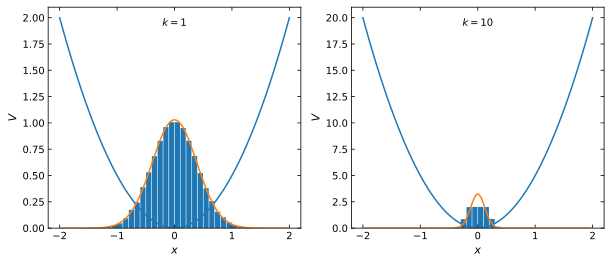

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
oscs = [Oscillator(k=1), Oscillator(k=10)]
for ax, osc in zip(axs, oscs):
    osc.plot(ax)
    ax.set(xlabel=r'$x$', ylabel=r'$V$')
    ax.text(0.5, 0.95, f'$k={osc.k}$', transform=ax.transAxes, ha='center', va='top')

fig.savefig('ex6_fig1.png')